# 만들어진 Doc2Vec model을 통한 감정분석 실시
> * Positive or Negative

In [ ]:
import pickle
import html
import multiprocessing
from collections import namedtuple, OrderedDict
import re
import sys

import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from gensim.models import doc2vec, KeyedVectors
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec

from konlpy.utils import pprint

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

from sklearn.preprocessing import scale
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.layers import Input, Dense, Embedding, embeddings, merge, Dropout, Activation
from keras.utils import np_utils

import matplotlib.pyplot as plt

In [80]:
def Make_Roc_Curve(x, y, model1, model2, model3):
    fpr1, tpr1, thresholds1 = roc_curve(y, model1.predict(x))
    fpr2, tpr2, thresholds2 = roc_curve(y, model2.predict(x))
    fpr3, tpr3, thresholds3 = roc_curve(y, model3.predict(x))
    plt.plot(fpr1, tpr1, label="Logistic Regression")
    plt.plot(fpr2, tpr2, label="RandomForest")
    plt.plot(fpr3, tpr3, label="Kernel SVM")
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--', label="random guess")
    plt.xlabel('False Positive Rate (Fall-Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('Receiver operating characteristic example')
    plt.show()

In [2]:
import gensim
gensim.__version__

'3.3.0'

* windows에서 모델을 만들때 사용한 gensim의 버전이 3.3이었고, mac에서는 버전이 맞지 않아서 만들어둔 모델을 불러오지 못하였음.

## Doc2Vec

In [3]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [ ]:
def Get_Infer_Vector(docs, model):
    return [model.infer_vector(doc.words) for doc in tqdm(docs)]

In [122]:
loadModelPath = '/Volumes/disk1/model/'
saveTrainPath = './data/pre_data/train_test_Data2/'
saveClassifierPath = './data/pre_data/classifier/'

### twitter

#### Load Model

In [114]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-ct.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-ct.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-ct.model')

#### Word to Vector

##### train set

In [5]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_train.pickled','rb'))

In [ ]:
train_x_by_m1 = Get_Infer_Vector(train, model1)
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
train_x_by_m2 = Get_Infer_Vector(train, model2)
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
train_x_by_m3 = Get_Infer_Vector(train, model3)
name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
train_y = [doc.tags[0] for doc in tqdm(train)]

pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
pickle.dump(train_y, open(saveTrainPath+'train_y_for_sentiment_analysis','wb'))

In [ ]:
del train

In [ ]:
del train_x_by_m1
del name1
del train_x_by_m2
del name2
del train_x_by_m3
del name3
del train_y

##### test set

In [17]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_ct_test.pickled','rb'))

In [ ]:
test_x_by_m1 = Get_Infer_Vector(test, model1)
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'ct'
test_x_by_m2 = Get_Infer_Vector(test, model2)
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'ct'
test_x_by_m3 = Get_Infer_Vector(test, model3)
name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'ct'
test_y = [doc.tags[0] for doc in tqdm(test)]

pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
pickle.dump(test_y, open(savePath+'test_y_for_sentiment_analysis','wb'))

In [ ]:
del test

In [ ]:
del test_x_by_m1
del name1
del test_x_by_m2
del name2
del test_x_by_m3
del name3
del test_y

In [ ]:
del model1
del model2
del model3

#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [151]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_for_sentiment_analysis','rb'))

In [152]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-ct'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [160]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.62
classification report
             precision    recall  f1-score   support

          0       0.68      0.56      0.61        54
          1       0.57      0.70      0.63        46

avg / total       0.63      0.62      0.62       100



In [161]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [162]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.55
classification report
             precision    recall  f1-score   support

          0       0.57      0.67      0.62        54
          1       0.51      0.41      0.46        46

avg / total       0.54      0.55      0.54       100



In [163]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [164]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m1, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.65
classification report
             precision    recall  f1-score   support

          0       0.70      0.61      0.65        54
          1       0.60      0.70      0.65        46

avg / total       0.66      0.65      0.65       100



In [165]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

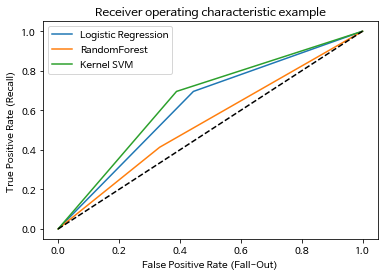

In [166]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [ ]:
del classifier
del classifier2
del classifier3

In [167]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [168]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_for_sentiment_analysis','rb'))

In [169]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-ct'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [170]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.57
classification report
             precision    recall  f1-score   support

          0       0.61      0.57      0.59        54
          1       0.53      0.57      0.55        46

avg / total       0.57      0.57      0.57       100



In [171]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [172]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.46
classification report
             precision    recall  f1-score   support

          0       0.50      0.61      0.55        54
          1       0.38      0.28      0.33        46

avg / total       0.45      0.46      0.45       100



In [173]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [174]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.58
classification report
             precision    recall  f1-score   support

          0       0.77      0.31      0.45        54
          1       0.53      0.89      0.66        46

avg / total       0.66      0.58      0.55       100



In [175]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

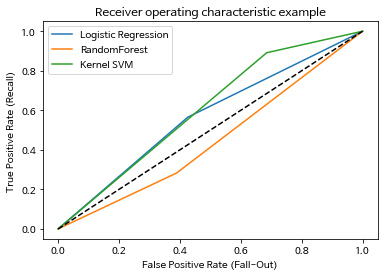

In [176]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [177]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name
del classifier
del classifier2
del classifier3

#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [101]:
name3

'Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'

In [178]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
train_x_by_m3 = pickle.load(open(savePath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(savePath+'train_y_for_sentiment_analysis','rb'))

In [179]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-ct'
test_x_by_m3 = pickle.load(open(savePath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(savePath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [180]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': 1, 'penalty': 'l2', 'random_state': 1234, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
score : 0.79
classification report
             precision    recall  f1-score   support

          0       0.80      0.81      0.81        54
          1       0.78      0.76      0.77        46

avg / total       0.79      0.79      0.79       100



In [181]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [182]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 1234, 'verbose': 0, 'warm_start': False}
score : 0.59
classification report
             precision    recall  f1-score   support

          0       0.60      0.70      0.65        54
          1       0.57      0.46      0.51        46

avg / total       0.59      0.59      0.58       100



In [183]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [184]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 2, 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
score : 0.73
classification report
             precision    recall  f1-score   support

          0       0.76      0.72      0.74        54
          1       0.69      0.74      0.72        46

avg / total       0.73      0.73      0.73       100



In [185]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

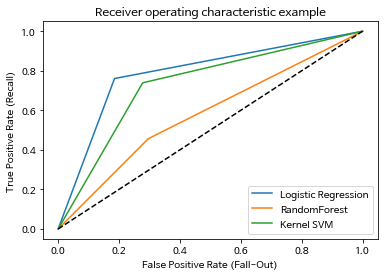

In [186]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [187]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name
del classifier
del classifier2
del classifier3

#### mecab

#### Load Model

In [188]:
model1 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-10_negative-7_hs-0_dm-1_dm_concat-0_dm_mean-1_by-mecab.model')
model2 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-5_negative-7_hs-0_dm-1_dm_concat-1_dm_mean-0_by-mecab.model')
model3 = doc2vec.Doc2Vec.load(loadModelPath+'doc2vec_size-2000_epoch-20_window-None_negative-7_hs-0_dm-0_dm_concat-0_dm_mean-0_by-mecab.model')

#### Word to Vector

##### train set

In [189]:
train = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_train.pickled','rb'))

In [ ]:
train = train[:1000]

In [ ]:
train_x_by_m1 = Get_Infer_Vector(train, model1)
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
train_x_by_m2 = Get_Infer_Vector(train, model2)
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
train_x_by_m3 = Get_Infer_Vector(train, model3)
name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
train_y = [doc.tags[0] for doc in tqdm(train)]

pickle.dump(train_x_by_m1,open(saveTrainPath+'train_x_'+name1,'wb'))
pickle.dump(train_x_by_m2,open(saveTrainPath+'train_x_'+name2,'wb'))
pickle.dump(train_x_by_m3,open(saveTrainPath+'train_x_'+name3,'wb'))
pickle.dump(train_y, open(saveTrainPath+'train_y_for_sentiment_analysis','wb'))

 27%|██▋       | 274/1000 [21:40<57:24,  4.74s/it]  

In [ ]:
del train

In [ ]:
del train_x_by_m1
del name1
del train_x_by_m2
del name2
del train_x_by_m3
del name3
del train_y

##### test set

In [ ]:
test = pickle.load(open('./data/pre_data/train_test_Data/pre_by_mecab_test.pickled','rb'))

In [ ]:
test = test[:100]

In [ ]:
test_x_by_m1 = Get_Infer_Vector(test, model1)
name1 = '-'.join(re.split('[\(\),\/]',str(model1)))+'mecab'
test_x_by_m2 = Get_Infer_Vector(test, model2)
name2 = '-'.join(re.split('[\(\),\/]',str(model2)))+'mecab'
test_x_by_m3 = Get_Infer_Vector(test, model3)
name3 = '-'.join(re.split('[\(\),\/]',str(model3)))+'mecab'
test_y = [doc.tags[0] for doc in tqdm(test)]

pickle.dump(test_x_by_m1,open(saveTrainPath+'test_x_'+name1,'wb'))
pickle.dump(test_x_by_m2,open(saveTrainPath+'test_x_'+name2,'wb'))
pickle.dump(test_x_by_m3,open(saveTrainPath+'test_x_'+name3,'wb'))
pickle.dump(test_y, open(savePath+'test_y_for_sentiment_analysis','wb'))

In [ ]:
del test

In [ ]:
del test_x_by_m1
del name1
del test_x_by_m2
del name2
del test_x_by_m3
del name3
del test_y

In [ ]:
del model1
del model2
del model3

#### model1
* Doc2Vec(dm/m,d2000,n7,w10,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-10
* negative-7
* hs-0
* dm-1
* dm_concat-0
* dm_mean-1

In [ ]:
train_x_by_m1_name = 'train_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
train_x_by_m1 = pickle.load(open(saveTrainPath+train_x_by_m1_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m1_name = 'test_x_Doc2Vec-dm-m-d2000-n7-w10-mc5-s0.001-t12-mecab'
test_x_by_m1 = pickle.load(open(saveTrainPath+test_x_by_m1_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m1, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m1, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m1_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m1, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m1, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m1)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m1_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m1, test_y, classifier, classifier2, classifier3)

In [ ]:
del train_x_by_m1
del train_x_by_m1_name
del test_x_by_m1
del test_x_by_m1_name
del classifier
del classifier2
del classifier3

#### model2
* Doc2Vec(dm/c,d2000,n7,w5,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-5
* negative-7
* hs-0
* dm-1
* dm_concat-1
* dm_mean-0

In [ ]:
train_x_by_m2_name = 'train_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
train_x_by_m2 = pickle.load(open(saveTrainPath+train_x_by_m2_name,'rb'))
train_y = pickle.load(open(saveTrainPath+'train_y_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m2_name = 'test_x_Doc2Vec-dm-c-d2000-n7-w5-mc5-s0.001-t12-mecab'
test_x_by_m2 = pickle.load(open(saveTrainPath+test_x_by_m2_name,'rb'))
test_y = pickle.load(open(saveTrainPath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m2, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m2, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m2_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m2, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m2, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m2)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m2_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m2, test_y, classifier, classifier2, classifier3)

In [ ]:
del train_x_by_m2
del train_x_by_m2_name
del test_x_by_m2
del test_x_by_m2_name
del classifier
del classifier2
del classifier3

#### model3
* Doc2Vec(dbow,d2000,n7,mc5,s0.001,t12)
* size-2000
* epoch-20
* window-None
* negative-7
* hs-0
* dm-0
* dm_concat-0
* dm_mean-0

In [ ]:
name3

In [ ]:
train_x_by_m3_name = 'train_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
train_x_by_m3 = pickle.load(open(savePath+train_x_by_m3_name,'rb'))
train_y = pickle.load(open(savePath+'train_y_for_sentiment_analysis','rb'))

In [ ]:
test_x_by_m3_name = 'test_x_Doc2Vec-dbow-d2000-n7-mc5-s0.001-t12-mecab'
test_x_by_m3 = pickle.load(open(savePath+test_x_by_m3_name,'rb'))
test_y = pickle.load(open(savePath+'test_y_for_sentiment_analysis','rb'))

#### 분류 모델 : Logistic Regression

In [ ]:
classifier = LogisticRegression(random_state=1234)
classifier.fit(train_x_by_m3, train_y)
print (classifier.get_params())
print( 'score : {}'.format(classifier.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier,open(saveClassifierPath+'LogisticRegression_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : RandomForest Classifier

In [ ]:
classifier2 = RandomForestClassifier(random_state=1234)
classifier2.fit(train_x_by_m3, train_y)
print (classifier2.get_params())
print( 'score : {}'.format(classifier2.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier2.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier2,open(saveClassifierPath+'RandomForestClassifier_'+train_x_by_m3_name, 'wb'))

#### 분류모델 : C-Support Vector Classification

In [ ]:
classifier3 = SVC(kernel = 'linear', gamma = 2)
classifier3.fit(train_x_by_m3, train_y)
print (classifier3.get_params())
print( 'score : {}'.format(classifier3.score(test_x_by_m3, test_y)))
print ('classification report')
print (classification_report(test_y, classifier3.predict(test_x_by_m3)))

In [ ]:
pickle.dump(classifier3,open(saveClassifierPath+'SVC_'+train_x_by_m3_name, 'wb'))

In [ ]:
Make_Roc_Curve(test_x_by_m3, test_y, classifier, classifier2, classifier3)

In [ ]:
del train_x_by_m3
del train_x_by_m3_name
del test_x_by_m3
del test_x_by_m3_name
del classifier
del classifier2
del classifier3

#### 분류모델 : 

In [ ]:

train_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x,train_x_by_m3))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([z.reshape(1,-1) for z in tqdm(map(lambda x: x, test2_x))])
test_vecs_w2v = scale(test_vecs_w2v)


y_test2 = np_utils.to_categorical(test2_y,2)
y_train2 = np_utils.to_categorical(train2_y,2)

In [ ]:

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=2000))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(#optimizer='rmsprop',
    optimizer='adadelta',
              #loss='binary_crossentropy',
    #optimizer=SGD(lr=0.2), 
    loss='binary_crossentropy',
    metrics=['accuracy'])

model.fit(train_vecs_w2v, y_train2,epochs=100, batch_size=50000, verbose=2)
score = model.evaluate(test_vecs_w2v, y_test2, verbose=2)
print (score[1])

In [ ]:
mode2 = Sequential()
mode2.add(Dense(64, activation='relu', input_dim=2000))
mode2.add(Dropout(0.25))
mode2.add(Dense(32, activation='relu'))
mode2.add(Dropout(0.125))
mode2.add(Dense(2, activation='softmax'))
mode2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train model
mode2.fit(train_vecs_w2v, y_train2,epochs=100, batch_size=50000, verbose=2)
# Evaluate model
score, acc = model.evaluate(test_vecs_w2v, y_test2, verbose=2)


print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

In [ ]:
embedding_layer = Embedding(input_dim=len(list(model2.docvecs)),
                           output_dim = 2000)

In [ ]:
from keras.layers import Activation
nn_model = Sequential()
nn_model.add(embedding_layer)
nn_model.add(LSTM(2))
nn_model.add(Dense(2))
nn_model.add(Activation('sigmoid'))
nn_model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
print('Train...')
nn_model.fit(train_vecs_w2v, y_train2,epochs=10, batch_size=25000)
# Evaluate model
score, acc = nn_model.evaluate(test_vecs_w2v, y_test2, verbose=2)